In [190]:
import os
import pandas as pd 
import numpy as np
import glob 
import itertools
import upsetplot
from matplotlib import pyplot as plt
from qmplot import manhattanplot
import seaborn as sns
import pybedtools as pbt 
from matplotlib_venn import venn2, venn3, venn3_circles

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

pbt.set_bedtools_path('/mnt/BioHome/jreyna/software/anaconda3/envs/hic_tls/bin/')
pbt.set_tempdir('/mnt/hpcscratch/jreyna/')

gsizes = 'results/refs/hg38/hg38.chrom.sizes'

os.chdir('/mnt/BioHome/jreyna/jreyna/projects/dchallenge')

outdir = 'results/main/gwas/summary/'
os.makedirs(outdir, exist_ok=True)

In [2]:
gwas_samplesheet = pd.read_table('config/gwas_samplesheets/gwas.samplesheet.tsv')

In [3]:
gwas_samplesheet.set_index('gwas_id', inplace=True)

## Loading Significant GWASes 

In [4]:
gwas_sss = 'results/main/2021_Nikhil_eQTL/Data/T1D_GWAS/*/GRCh38/GWAS_input_colocalization_pval_lt_5eMinus8.txt'
gwas_sss = glob.glob(gwas_sss)
gwas_sss

['results/main/2021_Nikhil_eQTL/Data/T1D_GWAS/T1D_25751624/GRCh38/GWAS_input_colocalization_pval_lt_5eMinus8.txt',
 'results/main/2021_Nikhil_eQTL/Data/T1D_GWAS/T1D_34594039_GCST90018705/GRCh38/GWAS_input_colocalization_pval_lt_5eMinus8.txt',
 'results/main/2021_Nikhil_eQTL/Data/T1D_GWAS/T1D_34012112_Gaulton/GRCh38/GWAS_input_colocalization_pval_lt_5eMinus8.txt',
 'results/main/2021_Nikhil_eQTL/Data/T1D_GWAS/T1D_32005708/GRCh38/GWAS_input_colocalization_pval_lt_5eMinus8.txt',
 'results/main/2021_Nikhil_eQTL/Data/T1D_GWAS/T1D_34594039_GCST90018925/GRCh38/GWAS_input_colocalization_pval_lt_5eMinus8.txt']

In [5]:
data = []
for fn in gwas_sss:
    gwas_source = fn.split('/')[5]
    
    if gwas_source in gwas_samplesheet.index.tolist():
        df = pd.read_table(fn, sep= ' ')
        df['gwas_source'] = gwas_source
        data.append(df)

In [6]:
gwas_data = pd.concat(data)

# adding a variant ID for downstream analyses
gwas_data['var_id'] = gwas_data['CHR'].str.replace('chr', '') + ':' + gwas_data['POS'].astype(str)

## Number of GWAS Variants by Study

In [7]:
gwas_grps = gwas_data.groupby(['gwas_source'])
study_summary = gwas_grps['var_id'].nunique().to_frame()
study_summary.columns = ['num_vars']
study_summary = study_summary.merge(gwas_samplesheet[['authorship']],
                    left_on='gwas_source', right_index=True)

In [8]:
# make the final summary table
final_df = study_summary[['authorship', 'num_vars']]
final_df.columns = ['GWAS Source', 'Number of Sig. GWAS']
final_df

GWAS Source  Number of Sig. GWAS
gwas_source                                                                 
T1D_25751624               Onengut-Gumuscu et al., 2015                 1722
T1D_32005708                      Forgetta et al., 2020                21097
T1D_34012112_Gaulton                 Chiou et al., 2021                45798
T1D_34594039_GCST90018925           Sakaue et al., 2021                20419

In [9]:
final_df.iloc[:, 1].tolist()

[1722, 21097, 45798, 20419]

## Making a simple barplot

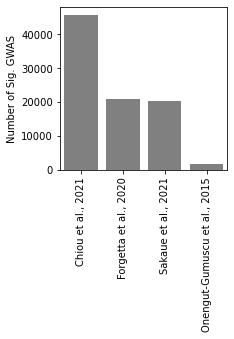

In [10]:
simple_data = final_df.sort_values('Number of Sig. GWAS', ascending=False)
fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(x='GWAS Source', y='Number of Sig. GWAS',
            data=simple_data, color='grey', 
           ax=ax)

ax.set_xlabel('')

ax.set_xticklabels(simple_data['GWAS Source'], rotation = 90)

simple_fn = os.path.join(outdir, 'gwas.simple_barplot.svg')
fig.savefig(simple_fn)

## Making an upset plot of overlaps

https://github.com/ShujiaHuang/qmplot

In [11]:
# converting from dataframe groups to dict format 
var_members = {}
for gwas_source, gwas_df in gwas_grps:
    authorship = gwas_samplesheet.loc[gwas_source, 'authorship']
    var_members[authorship] = gwas_df.var_id.unique().tolist()
    print(len(var_members[authorship]))

1722
21097
45798
20419


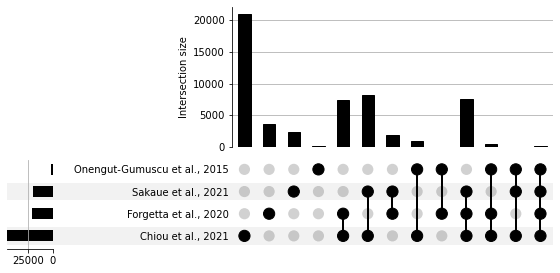

In [206]:
# making the upset input dataframe
upset_input = upsetplot.from_contents(var_members)

# plotting the upset plot
plot = upsetplot.UpSet(upset_input, subset_size='count').plot()

#### Getting some details

In [14]:
count_chiou = upset_input.loc[(upset_input.index.get_level_values(2) == True)]

In [15]:
count_chiou.shape

(45798, 1)

In [16]:
count_chiou = upset_input.loc[(upset_input.index.get_level_values(0) == False) & 
                (upset_input.index.get_level_values(1) == False) & 
                (upset_input.index.get_level_values(2) == True) & 
                (upset_input.index.get_level_values(3) == False)]

In [17]:
count_chiou.shape

(20981, 1)

In [18]:
count_shared = upset_input.loc[(upset_input.index.get_level_values(0) == True) & 
                (upset_input.index.get_level_values(1) == True) & 
                (upset_input.index.get_level_values(2) == True) & 
                (upset_input.index.get_level_values(3) == True)]

In [19]:
count_shared.shape

(191, 1)

In [20]:
count_wgs = upset_input.loc[(upset_input.index.get_level_values(0) == False) & 
                (upset_input.index.get_level_values(1) == True) & 
                (upset_input.index.get_level_values(2) == True) & 
                (upset_input.index.get_level_values(3) == True)]

In [21]:
count_wgs.shape

(7593, 1)

## Making a GWAS Plot For Each (Filtered) Dataset 

https://upsetplot.readthedocs.io/en/stable/formats.html

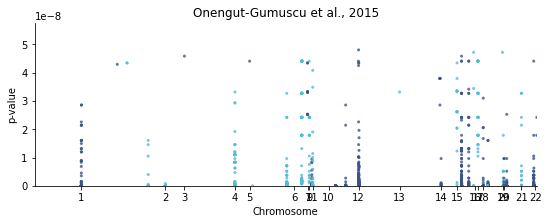

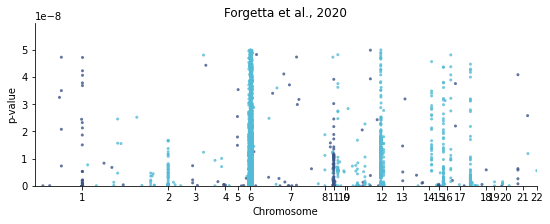

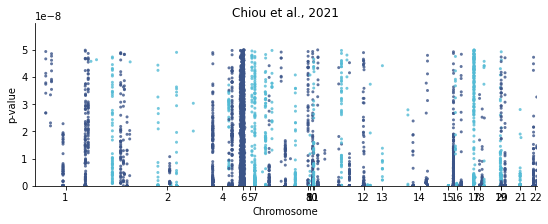

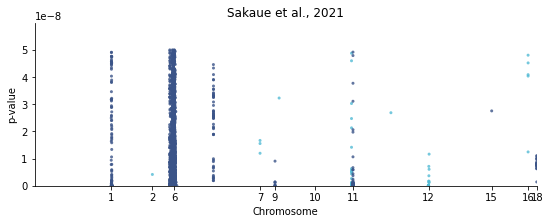

In [22]:
# generate manhattan plot and set an output file.
i = 0
for gwas_source, gwas_df in gwas_grps:
    
    title = gwas_samplesheet.loc[gwas_source, 'authorship']
    
    # remove chr for plotting purposes
    plot_df = gwas_df.copy()
    plot_df.loc[:, 'CHR'] = plot_df['CHR'].str.replace('chr', '').astype(int)
    plot_df.sort_values('CHR', inplace=True)
        
    # plot and save
    outfn = os.path.join(outdir, '{}.png'.format(gwas_source))
    manhattanplot(data=plot_df,
                       chrom='CHR',
                       pos='POS',
                       pv='P', 
                       title = title, 
                       ylabel='p-value',
                       suggestiveline=None,
                       genomewideline=None,
                       is_show=True,
                       figname=outfn,
                       logp=False)
    i += 1 
    

## Loading GWAS Plots For Each (Un-Filtered) Dataset 

These plots were made using:

    1) workflow/scripts/gwas/convert_gwas_catalog_to_plink.sh
    2) workflow/scripts/gwas/plot_manhattan_plot.py
    
Still not complete. Need to convert from the GWAS Catalog format and into the Plink Format (step 1).

In [23]:
from IPython.display import Image, display
from IPython.core.display import HTML 

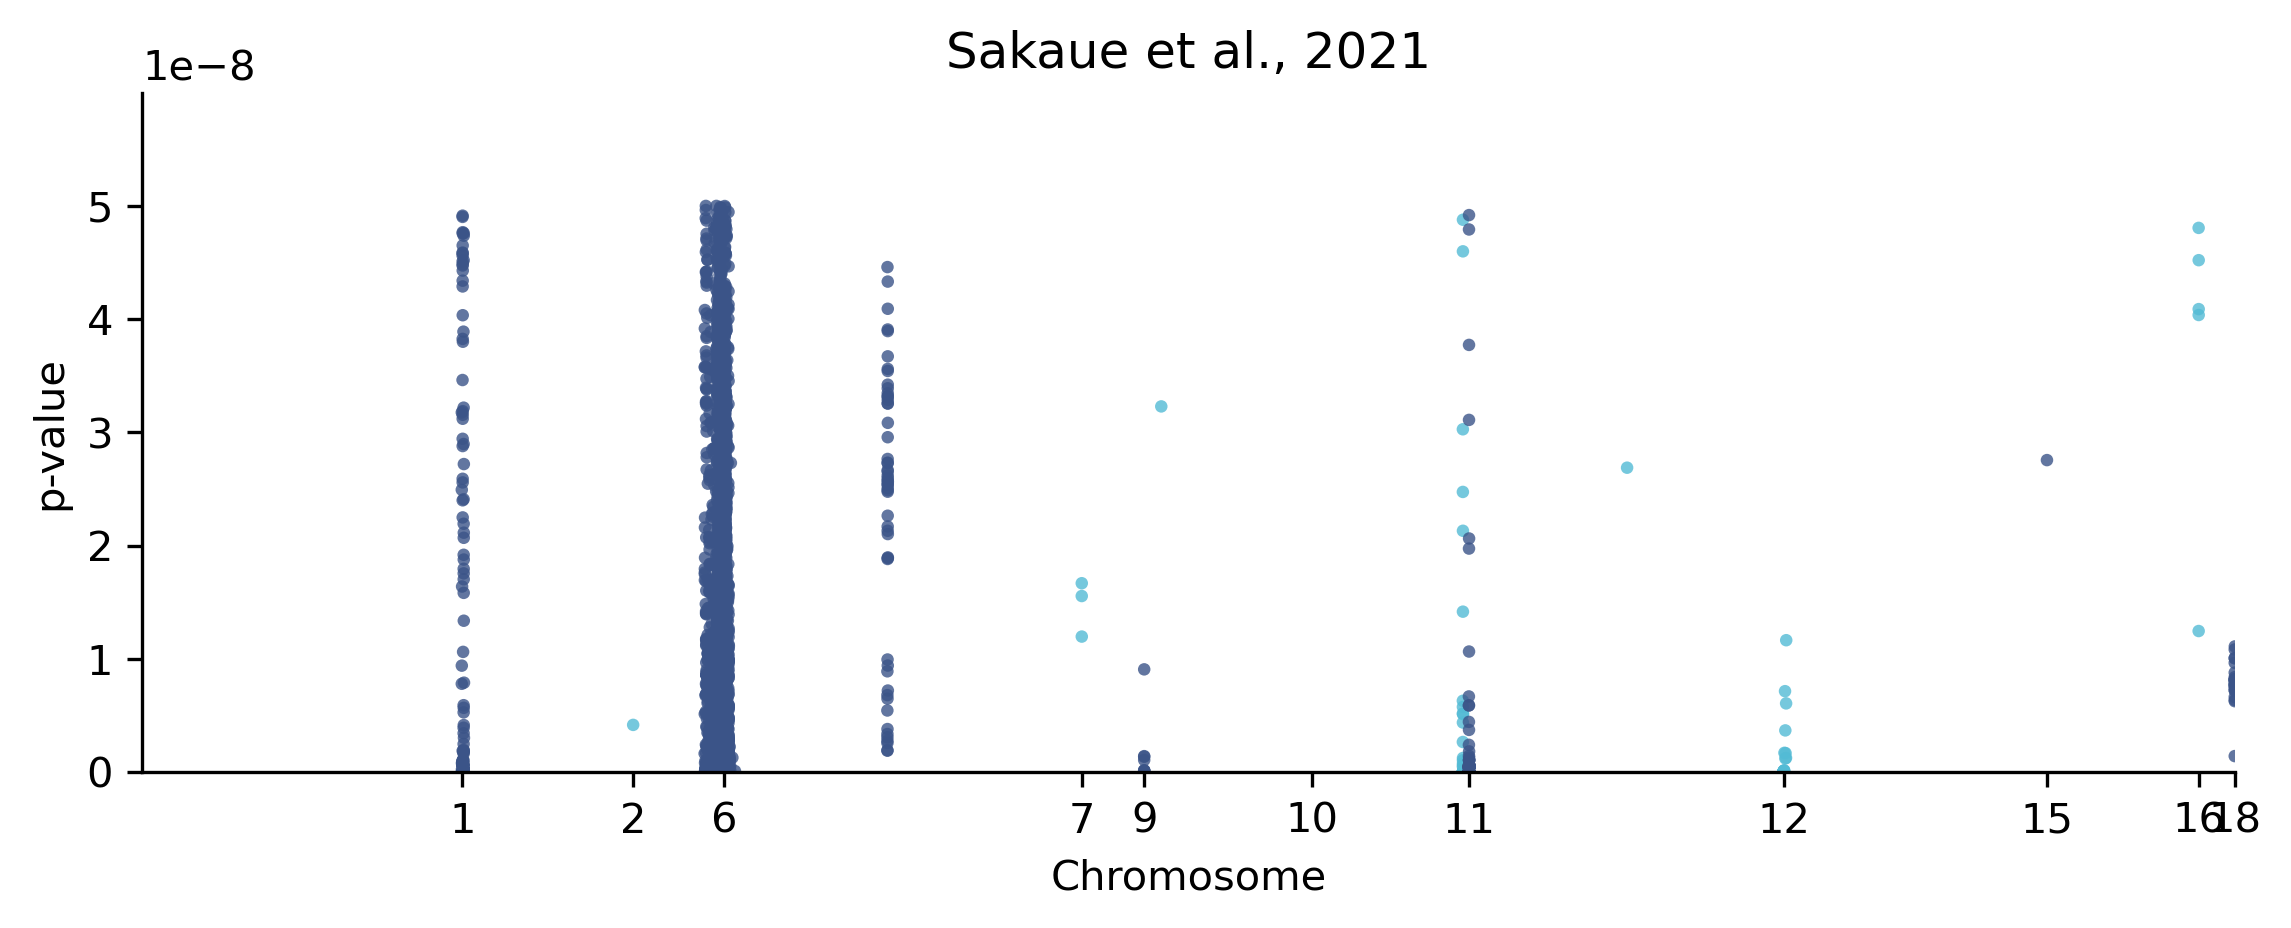

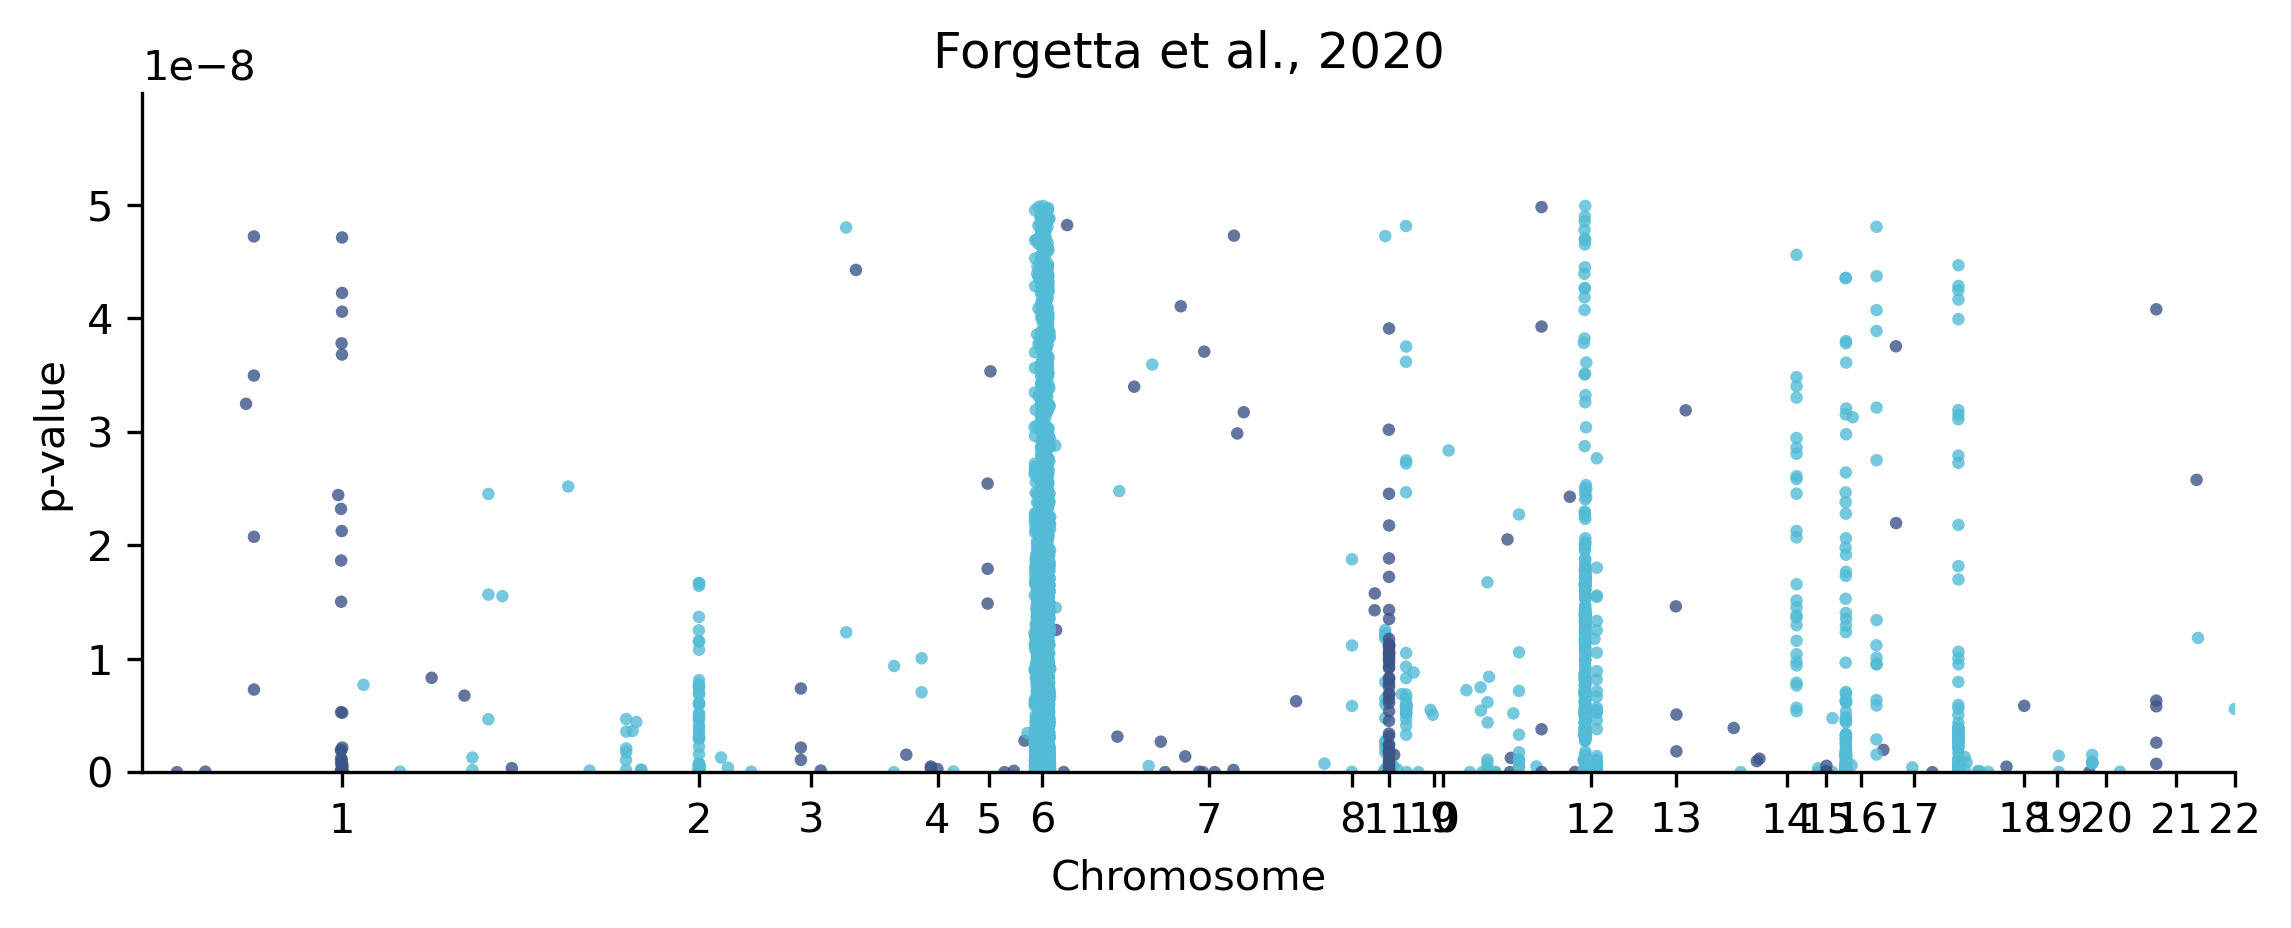

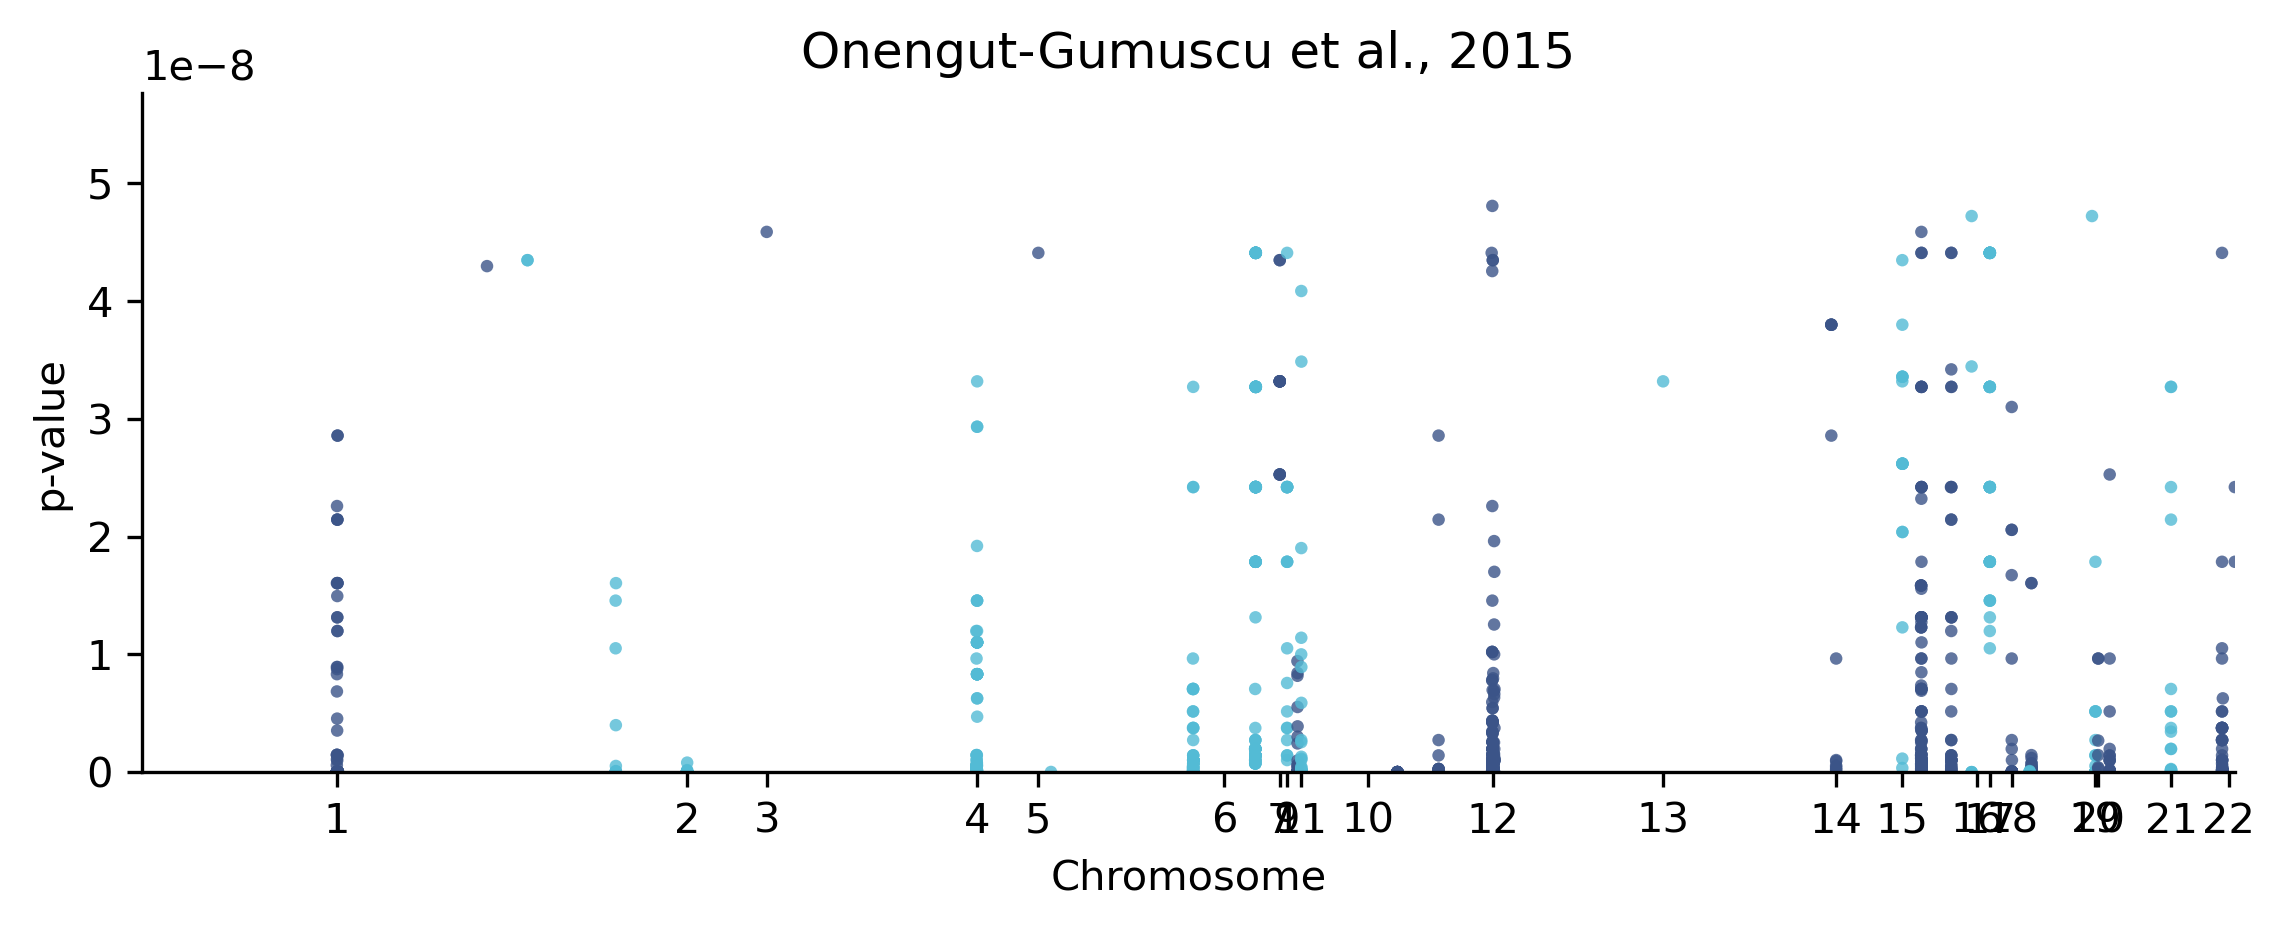

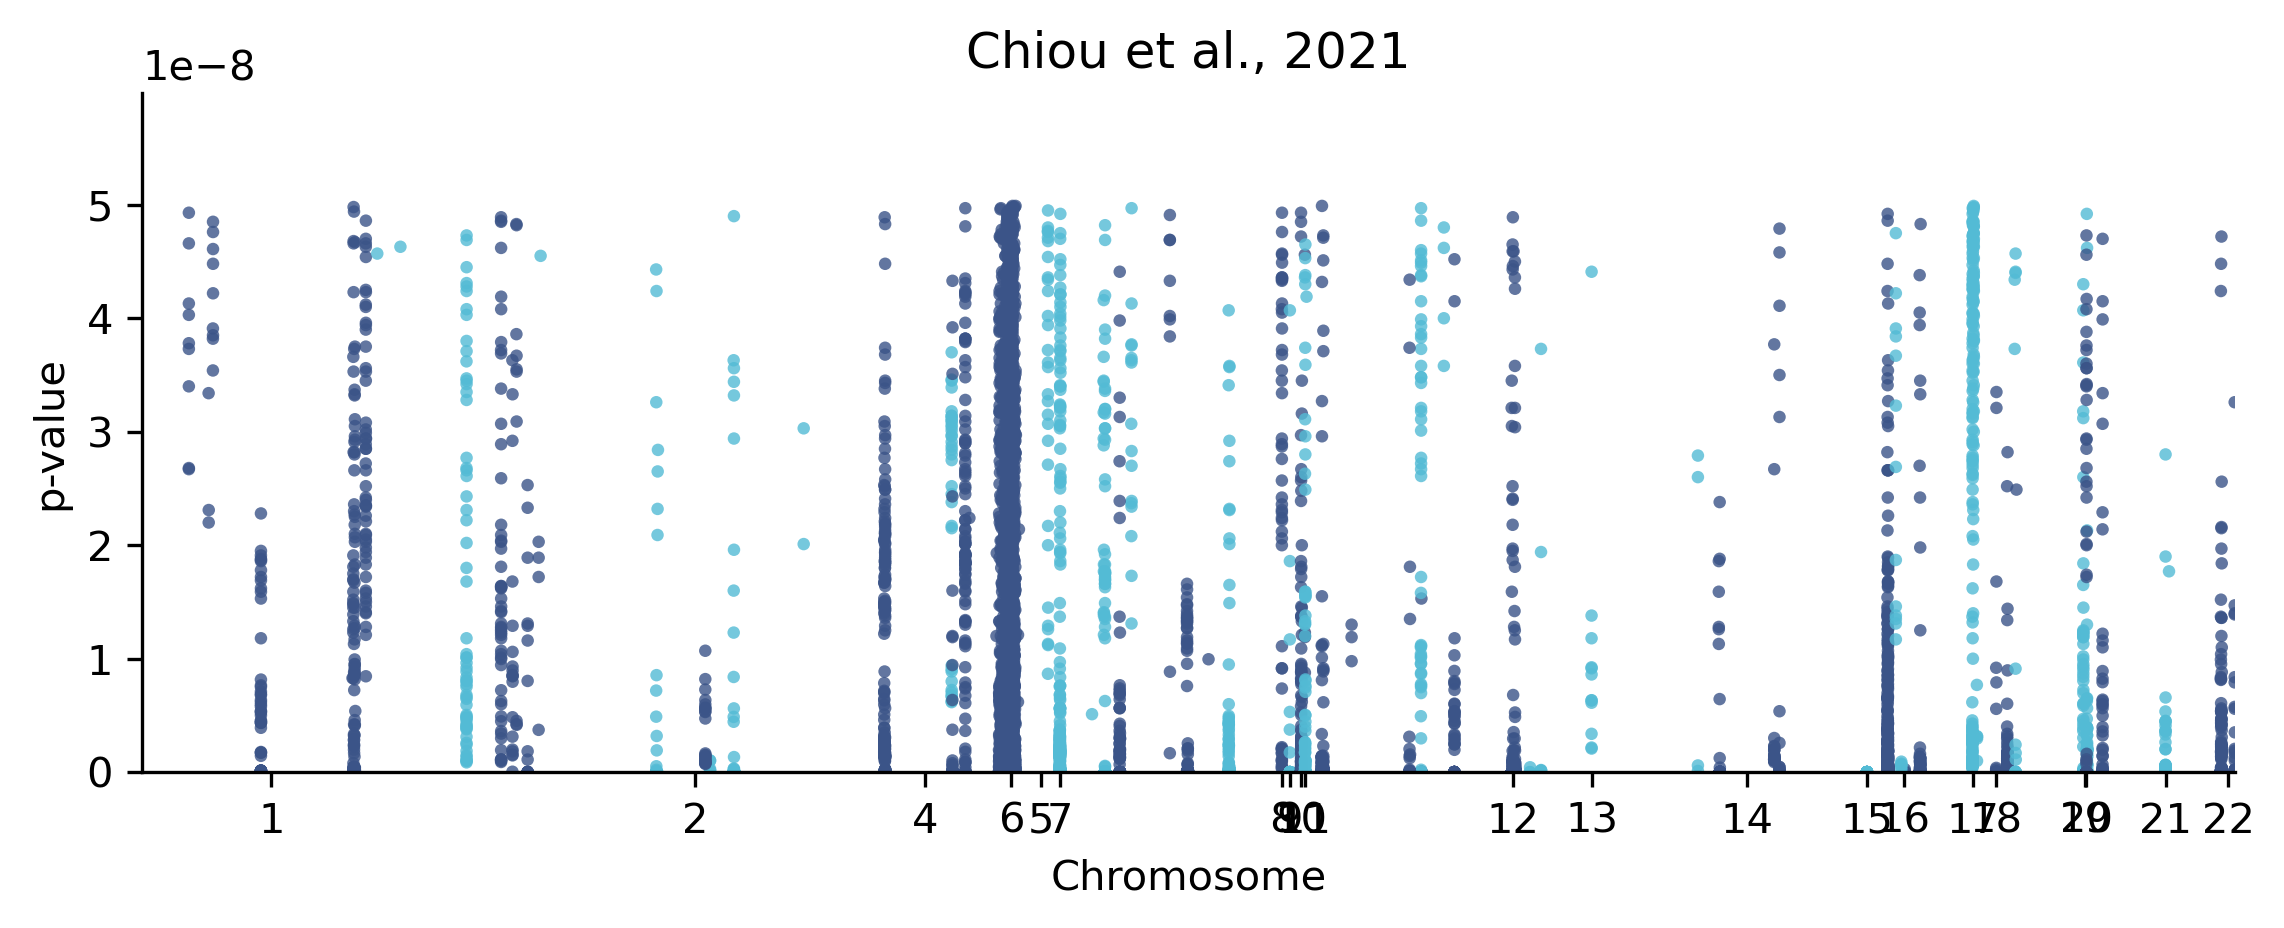

In [24]:
for fn in glob.glob('results/main/gwas/summary/*.png'):
    display(Image(data=fn, width=500, height=400))

## Overlap with genes

In [25]:
print('# Load the gene data')

genes_fn = 'results/refs/gencode/v30/gencode.v30.annotation.bed'

# load the gencode coords
cols = ['chrom', 'start', 'end', 'strand', 'type', 'gene_id', 'gname']
gencode = pd.read_table(genes_fn, header=None, names=cols)

# extract just the genes
genes_df = gencode.loc[gencode['type'].isin(['gene'])]
genes_df = genes_df.loc[~genes_df.duplicated(subset='gene_id'), :]
genes_df.loc[:, 'chrom'] = genes_df['chrom'].astype(str)
genes_df = genes_df.iloc[:, [0,1,2,6,5,3]]

# create a copy of the original gene bed before coordinate shrinking
orig_genes_df = genes_df.copy()

# convert the start/end position into start/end for the TSS
# if the gene is + then the start is uses as the tss otherwise
# the end is used as the tss
# genes_df.loc[(genes_df.strand == '+'), 'end'] = genes_df.loc[(genes_df.strand == '+'), 'start']
# genes_df.loc[(genes_df.strand == '+'), 'start'] = genes_df.loc[(genes_df.strand == '+'), 'start'] - 1
# genes_df.loc[(genes_df.strand == '-'), 'end'] = genes_df.loc[(genes_df.strand == '-'), 'end']
# genes_df.loc[(genes_df.strand == '-'), 'start'] = genes_df.loc[(genes_df.strand == '-'), 'end'] - 1
# genes_df.loc[:, 'chrom'] = genes_df.loc[:, 'chrom'].str.replace('chr', '')
# genes_df.loc[:, 'bin_start'] = (np.floor(genes_df.loc[:, 'start'] / res) * res).astype(int)
# genes_df.loc[:, 'bin_end'] = genes_df.loc[:, 'bin_start'] + res

# make a genes pbt for intersection
print("# make a genes pbt for intersection")
print(genes_df.head())
genes_pbt = pbt.BedTool.from_dataframe(genes_df).sort()

print('There are {} genes in this GTF-derived file.'.format(genes_df.shape[0]))

# Load the gene data
# make a genes pbt for intersection
   chrom  start    end        gname          gene_id strand
0   chr1  11869  14409      DDX11L1  ENSG00000223972      +
12  chr1  14404  29570       WASH7P  ENSG00000227232      -
25  chr1  17369  17436    MIR6859-1  ENSG00000278267      -
28  chr1  29554  31109  MIR1302-2HG  ENSG00000243485      +
36  chr1  30366  30503    MIR1302-2  ENSG00000284332      +
There are 58825 genes in this GTF-derived file.


In [26]:
gwas_data['START'] = gwas_data['POS'] - 1
gwas_pbt = pbt.BedTool.from_dataframe(gwas_data[['CHR', 'START', 'POS', 'gwas_source']])
gwas_gene_overlap = gwas_pbt.intersect(genes_pbt, wao=True)
gwas_gene_overlap = gwas_gene_overlap.to_dataframe()
gwas_gene_overlap.columns = ['chrom',
                             'start',
                             'end',
                             'gwas_source',
                             'chr_gene',
                             'start_gene',
                             'end_gene',
                             'genename',
                             'geneid',
                             'blockCount',
                             'bp_overlap']

display(gwas_gene_overlap)

chrom      start        end                gwas_source chr_gene  \
0       chr1  113276757  113276758               T1D_25751624        .   
1       chr1  113302201  113302202               T1D_25751624        .   
2       chr1  113305711  113305712               T1D_25751624        .   
3       chr1  113326434  113326435               T1D_25751624        .   
4       chr1  113329207  113329208               T1D_25751624        .   
...      ...        ...        ...                        ...      ...   
97869  chr18   12795420   12795421  T1D_34594039_GCST90018925    chr18   
97870  chr18   12795470   12795471  T1D_34594039_GCST90018925    chr18   
97871  chr18   12808140   12808141  T1D_34594039_GCST90018925    chr18   
97872  chr18   12808466   12808467  T1D_34594039_GCST90018925    chr18   
97873  chr18   12809340   12809341  T1D_34594039_GCST90018925    chr18   

       start_gene  end_gene genename           geneid blockCount  bp_overlap  
0              -1        -1        .               -1          .           0  
1              -1        -1        .               -1          .           0  
2              -1        -1        .               -1          .           0  
3              -1        -1        .               -1          .           0  
4              -1        -1        .               -1          .           0  
...           ...       ...      ...              ...        ...         ...  
97869    12785478  12929643    PTPN2  ENSG00000175354          -           1  
97870    12785478  12929643    PTPN2  ENSG00000175354          -           1  
97871    12785478  12929643    PTPN2  ENSG00000175354          -           1  
97872    12785478  12929643    PTPN2  ENSG00000175354          -           1  
97873    12785478  12929643    PTPN2  ENSG00000175354          -           1  

[97874 rows x 11 columns]

#### Number of non-coding versus coding

In [27]:
coding_versus_non = gwas_gene_overlap.bp_overlap.value_counts()
coding_versus_non = coding_versus_non.to_frame()
coding_versus_non.columns = ['count']
coding_versus_non['name'] = coding_versus_non.index.map({1: 'Gene Overlapping', 0: 'Intergenic'}).astype(str) + \
                                    ' (' + coding_versus_non['count'].astype(str) + ')'

display(coding_versus_non)

count                      name
1  53531  Gene Overlapping (53531)
0  44343        Intergenic (44343)

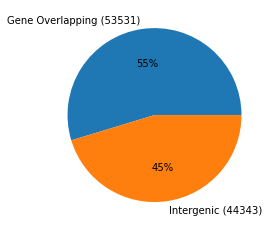

In [28]:
#create pie chart
fig, ax = plt.subplots()

ax.pie(coding_versus_non['count'], labels=coding_versus_non['name'], autopct='%.0f%%')

fn = os.path.join(outdir, 'gene_overlapping_versus_intergenic.svg')
fig.savefig(fn)

#### Show the subtypes of genes found

In [33]:
extra_gene_info_fn = 'results/refs/gencode/v30/gencode.v30.annotation.grch37.bed'

# load the gencode coords
cols = ['chrom', 'start', 'end', 'strand', 'type', 'geneid', 'genename', 'subtype']
extra_gene_info = pd.read_table(extra_gene_info_fn, header=None, names=cols, usecols=['geneid', 'type', 'subtype'])

# extract subtype information for genes
extra_gene_info = extra_gene_info.loc[extra_gene_info['type'].isin(['gene'])]
extra_gene_info = extra_gene_info.loc[~extra_gene_info.duplicated(subset='geneid'), :]
extra_gene_info.drop('type', axis=1, inplace=True)

In [34]:
# add extra information 
gwas_gene_overlap = gwas_gene_overlap.merge(extra_gene_info, on='geneid', how='left')
only_gene_overlaps = gwas_gene_overlap.loc[~gwas_gene_overlap.subtype.isna()]
only_gene_overlaps.drop_duplicates(subset=['geneid'], inplace=True)

display(only_gene_overlaps.head())

# calculate the number of genes of a certain type 
only_gene_overlaps_counts = only_gene_overlaps.subtype.value_counts().to_frame()
only_gene_overlaps_counts.columns = ['num_genes']

only_gene_overlaps_counts['pct'] = only_gene_overlaps_counts['num_genes'] / only_gene_overlaps_counts['num_genes'].sum()

display(only_gene_overlaps_counts)

/mnt/hpcscratch/jreyna//ipykernel_29144/3801650910.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_gene_overlaps.drop_duplicates(subset=['geneid'], inplace=True)


chrom      start        end   gwas_source chr_gene  start_gene   end_gene  \
17   chr1  113391449  113391450  T1D_25751624     chr1   113390515  113685923   
157  chr1  113701276  113701277  T1D_25751624     chr1   113696831  113759489   
185  chr1  113766549  113766550  T1D_25751624     chr1   113761832  113812476   
208  chr1  113814588  113814589  T1D_25751624     chr1   113812379  113829171   
209  chr1  113814588  113814589  T1D_25751624     chr1   113813811  113871753   

       genename           geneid blockCount  bp_overlap       subtype_x  \
17        MAGI3  ENSG00000081026          +           1  protein_coding   
157       PHTF1  ENSG00000116793          -           1  protein_coding   
185       RSBN1  ENSG00000081019          -           1  protein_coding   
208  AL137856.1  ENSG00000231128          +           1       antisense   
209      PTPN22  ENSG00000134242          -           1  protein_coding   

          subtype_y         subtype  
17   protein_coding  protein_coding  
157  protein_coding  protein_coding  
185  protein_coding  protein_coding  
208       antisense       antisense  
209  protein_coding  protein_coding

num_genes       pct
protein_coding                            521  0.593394
lincRNA                                    80  0.091116
antisense                                  79  0.089977
processed_pseudogene                       66  0.075171
unprocessed_pseudogene                     60  0.068337
transcribed_unprocessed_pseudogene         16  0.018223
processed_transcript                       11  0.012528
misc_RNA                                    6  0.006834
transcribed_unitary_pseudogene              5  0.005695
unitary_pseudogene                          5  0.005695
transcribed_processed_pseudogene            5  0.005695
snRNA                                       4  0.004556
sense_intronic                              4  0.004556
TEC                                         3  0.003417
snoRNA                                      3  0.003417
miRNA                                       3  0.003417
sense_overlapping                           2  0.002278
3prime_overlapping_ncRNA                    2  0.002278
polymorphic_pseudogene                      1  0.001139
rRNA_pseudogene                             1  0.001139
bidirectional_promoter_lncRNA               1  0.001139

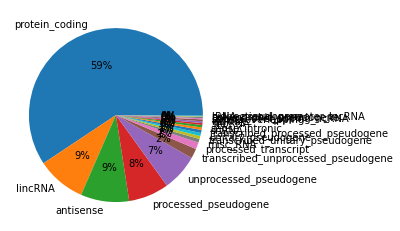

In [36]:
#create pie chart
plt.pie(only_gene_overlaps_counts['pct'], labels=only_gene_overlaps_counts.index, autopct='%.0f%%')
plt.show()

#### Show the subtypes of genes found in a simple form

In [37]:
# calculate the number of genes of a certain type 
sub_data = only_gene_overlaps_counts.iloc[0:5]['num_genes']

sub_data.loc['others'] = sum(only_gene_overlaps_counts[5:]['num_genes'])

sub_data = sub_data.to_frame()

display(sub_data)

sub_data['pct'] = sub_data['num_genes'] / sum(sub_data['num_genes'])


sub_data['proper_name'] = sub_data.index.map({'protein_coding': 'Protein Coding',
                                                'antisense': 'Antisense',
                                                'lincRNA': 'lincRNA', 
                                                'processed_pseudogene': 'Processed Pseudogene',
                                                'unprocessed_pseudogene': 'Unprocessed Pseudogene', 
                                                'others': 'Others'})
sub_data['full_name'] = sub_data.proper_name + ' ('  + sub_data['num_genes'].astype(str) +  ')'

In [40]:
sub_data

num_genes       pct             proper_name  \
protein_coding                521  0.593394          Protein Coding   
lincRNA                        80  0.091116                 lincRNA   
antisense                      79  0.089977               Antisense   
processed_pseudogene           66  0.075171    Processed Pseudogene   
unprocessed_pseudogene         60  0.068337  Unprocessed Pseudogene   
others                         72  0.082005                  Others   

                                          full_name  
protein_coding                 Protein Coding (521)  
lincRNA                                lincRNA (80)  
antisense                            Antisense (79)  
processed_pseudogene      Processed Pseudogene (66)  
unprocessed_pseudogene  Unprocessed Pseudogene (60)  
others                                  Others (72)

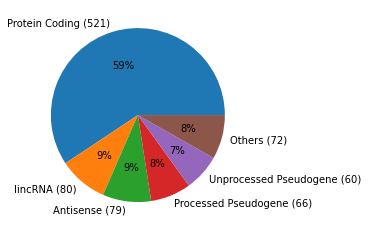

In [41]:
#create pie chart
fig, ax = plt.subplots()

#create pie chart
ax.pie(sub_data.num_genes, labels=sub_data.full_name, autopct='%.0f%%')

fn = os.path.join(outdir, 'genes_with_snps_in_body.svg')
fig.savefig(fn)

##### Saving only protein coding genes from GWAS-genes

In [42]:
fn = os.path.join(outdir, 'gwas_genes.all.txt')
only_gene_overlaps.genename.to_csv(fn, header=False, index=False)
prots_only = only_gene_overlaps.loc[only_gene_overlaps.subtype == 'protein_coding', 'genename']

display(prots_only)

fn = os.path.join(outdir, 'gwas_genes.prots.txt')
prots_only.to_csv(fn, header=False, index=False)

17          MAGI3
157         PHTF1
185         RSBN1
209        PTPN22
249       BCL2L15
           ...   
97489       RPS10
97491    C6orf106
97548        PAX4
97558      TCF7L2
97845         FTO
Name: genename, Length: 521, dtype: object

## Distribution of intergenic SNPs to GWAS-gene and intergenic SNPs to overall-closests

In [43]:
intergenic_snps = gwas_gene_overlap.loc[gwas_gene_overlap.subtype.isna()]
intergenic_snps_pbt = pbt.BedTool.from_dataframe(intergenic_snps[['chrom', 'start', 'end', 'gwas_source']])
intergenic_snps_pbt = intergenic_snps_pbt.sort()

##### Saving the closest genes to intergenic SNP (includes all genes)

In [93]:
isnps_all_closest = intergenic_snps_pbt.closest(genes_pbt, t='all', d=True).to_dataframe()
isnps_all_closest.columns = ['chr', 'start', 'end', 'gwas_source',
                         'chr_gene', 'start_gene', 'end_gene',
                         'genename', 'geneid', 'strand', 'dist']
isnps_all_closest = isnps_all_closest.merge(extra_gene_info, on='geneid')
isnps_all_closest = isnps_all_closest.loc[isnps_all_closest.subtype=='protein_coding']

fn = os.path.join(outdir, 'intergenic.closest_genes.all.txt')
isnps_all_closest_uniq = pd.Series(isnps_all_closest.geneid.unique())
isnps_all_closest_uniq.to_csv(fn, header=False, index=False)

##### Saving the closest genes to intergenic SNP (includes only GWAS-genes)

In [94]:
gwas_genes_pbt = pbt.BedTool.from_dataframe(
            only_gene_overlaps[['chr_gene', 'start_gene', 'end_gene', 'geneid']])
gwas_genes_pbt = gwas_genes_pbt.sort()

In [95]:
isnps_gwas_closest = intergenic_snps_pbt.closest(gwas_genes_pbt, t='all', d=True).to_dataframe()
isnps_gwas_closest.columns = ['chr', 'start', 'end', 'gwas_source',
                          'chr_gene', 'start_gene', 'end_gene', 'geneid', 'dist']

In [96]:
isnps_gwas_closest = isnps_gwas_closest.merge(extra_gene_info, on='geneid')
isnps_gwas_closest = isnps_gwas_closest.loc[isnps_gwas_closest.subtype=='protein_coding']

In [98]:
fn = os.path.join(outdir, 'intergenic.closest_genes.gwas_genes.txt')
isnps_gwas_closest_uniq = pd.Series(isnps_gwas_closest.geneid.unique())
isnps_gwas_closest_uniq.to_csv(fn, header=False, index=False)

##### Drawing a distribution plot

In [192]:
dist_vector = isnps_all_closest.dist.tolist() + isnps_gwas_closest.dist.tolist()
dist_labels = ['Closest Genes'] * isnps_all_closest.shape[0] + ['Closests GWAS-genes'] * isnps_gwas_closest.shape[0]
dist_data = pd.DataFrame([dist_vector, dist_labels]).T
dist_data.columns = ['dist', 'cat']

In [193]:
def log_dist(x):
    return(np.log10(x))

In [194]:
dist_data['ldist'] = dist_data['dist'].apply(log_dist)

/mnt/BioHome/jreyna/jreyna/software/mambaforge/envs/hichip-db/lib/python3.9/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/mnt/BioHome/jreyna/jreyna/software/mambaforge/envs/hichip-db/lib/python3.9/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


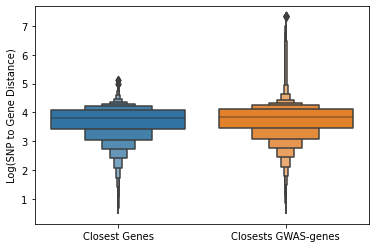

In [195]:
fig, ax = plt.subplots()
sns.boxenplot(x='cat', y='ldist', data=dist_data)

ax.set_xlabel('')
ax.set_ylabel('Log(SNP to Gene Distance)')

fn = os.path.join(outdir, 'snp_to_gene.closest_distance.svg')
fig.savefig(fn, transparent=False)

In [ ]:
isnps_all_closest.dist.tolist() + isnps_gwas_closest.dist.tolist()

In [202]:
from scipy.stats import ttest_ind, wilcoxon, ranksums

In [197]:
ttest_ind(isnps_all_closest.dist.tolist(), isnps_gwas_closest.dist.tolist())

Ttest_indResult(statistic=-8.47242396974602, pvalue=2.4739765691954195e-17)

In [203]:
ranksums(isnps_all_closest.dist.tolist(), isnps_gwas_closest.dist.tolist())

RanksumsResult(statistic=-5.541424305478038, pvalue=3.0002126077188736e-08)

In [198]:
isnps_all_closest.dist.describe()

count     22352.000000
mean       8405.465462
std        8100.884697
min           0.000000
25%        2634.000000
50%        6306.500000
75%       12385.750000
max      137856.000000
Name: dist, dtype: float64

In [199]:
isnps_gwas_closest.dist.describe()

count    2.333300e+04
mean     4.347249e+04
std      6.187476e+05
min      0.000000e+00
25%      2.825000e+03
50%      6.713000e+03
75%      1.285300e+04
max      2.164932e+07
Name: dist, dtype: float64

## Check the intersect

In [145]:
isnps_all_closest_set = set(isnps_all_closest_uniq.values)
isnps_gwas_closest_set = set(isnps_gwas_closest_uniq.values)

In [157]:
def set_comparison(x, y, x_label='x_only', y_label='y_only'):
    
    shared = x.intersection(y)
    x_only = x.difference(y)
    y_only = y.difference(x)
    union = x.union(y)
    
    d = {'Shared': shared, x_label: x_only, y_label: y_only, 'Total': union}
    
    return(d)

In [158]:
compr = set_comparison(isnps_all_closest_set, isnps_gwas_closest_set, x_label='All', y_label='GWAS Genes')

In [159]:
print({k: len(v) for k,v in compr.items()})

{'Shared': 280, 'All': 49, 'GWAS Genes': 42, 'Total': 371}


In [171]:
all_gwas_compr = pd.DataFrame.from_dict({k: len(v) for k,v in compr.items()}, orient='index')
all_gwas_compr.columns = ['count']
all_gwas_compr.drop('Total', inplace=True)
all_gwas_compr['names'] = all_gwas_compr.index

In [172]:
all_gwas_compr

count       names
Shared        280      Shared
All            49         All
GWAS Genes     42  GWAS Genes

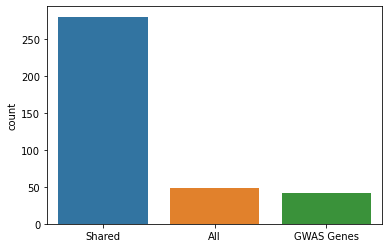

In [185]:
fig, ax = plt.subplots()

sns.barplot(x='names', y='count', data=all_gwas_compr)

ax.set_xlabel('')

fn = os.path.join(outdir, 'overlapping_genes.all_versus_gwas-genes.barplot.svg')
fig.savefig(fn)

In [176]:
all_gwas_compr

count       names
Shared        280      Shared
All            49         All
GWAS Genes     42  GWAS Genes

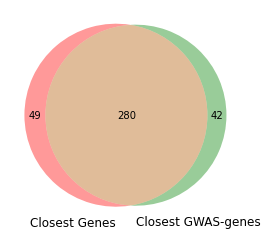

In [189]:
fig, ax = plt.subplots()
venn2([isnps_all_closest_set, isnps_gwas_closest_set], 
        set_labels=['Closest Genes', 'Closest GWAS-genes'])

fn = os.path.join(outdir, 'overlapping_genes.all_versus_gwas-genes.vennplot.svg')
fig.savefig(fn, transparent=False, )